In [ ]:
import pandas as pd 
from google.colab import files
data_to_load = files.upload()

In [ ]:
import io
df = pd.read_csv(io.BytesIO(data_to_load['Kickstarter_Kaggle.csv']))

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from timeit import default_timer as timer

# Nettoyage des données

In [ ]:
def first_infos(df):

    n_cols = len(df.columns)
    n_rows = len(df)
    n_na = df.isna().sum().sum()

    return(n_cols, n_rows, n_na)

first_infos(df)

(19, 217245, 0)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217245 entries, 0 to 217244
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     217245 non-null  int64  
 1   id             217245 non-null  int64  
 2   name           217245 non-null  object 
 3   currency       217245 non-null  object 
 4   launched_at    217245 non-null  object 
 5   backers_count  217245 non-null  int64  
 6   blurb          217245 non-null  object 
 7   country        217245 non-null  object 
 8   deadline       217245 non-null  object 
 9   slug           217245 non-null  object 
 10  status         217245 non-null  object 
 11  usd_pledged    217245 non-null  float64
 12  sub_category   217245 non-null  object 
 13  main_category  217245 non-null  object 
 14  creator_id     217245 non-null  int64  
 15  blurb_length   217245 non-null  int64  
 16  goal_usd       217245 non-null  float64
 17  city           217245 non-nul

In [ ]:
df.nunique()

Unnamed: 0       217245
id               192888
name             192263
currency             15
launched_at      192696
backers_count      3438
blurb            191219
country              25
deadline         181261
slug             192888
status                4
usd_pledged       89142
sub_category         15
main_category       159
creator_id       164681
blurb_length        152
goal_usd          12153
city              13409
duration             93
dtype: int64

De ce qu'il en ressort, le dataset est assez propre : 
*   Le dataset est assez propre (absence de NAN);
*   Beaucoup de variables sont composées d'un grand nombre de valeurs uniques, un traitement devra se faire à ce niveau;
*   De ce qu'il en ressort, les duplicates sont un volet à traiter;
*   Il y figure une erreur dans les intitulés entre les variables: mainsub_category, main_category qu'il faudra reprendre.






In [ ]:

# Transformation de la variable cible en valeurs indicative
df.loc[df['status'] == 'successful', 'status'] = 1
df.loc[df['status'] == 'failed', 'status'] = 0
df['status'].value_counts()

# Suppression des projets annulés 
df= df[df.status!=('canceled')]

# stocker les projets avec le status 'live' qui nous servirons d'exemple dans la prédiction
df_live=df[df.status==('live')]
df= df[df.status!=('live')]

df['status'] = df['status'].astype('int')
df['status'].value_counts()

df.status.value_counts()

# supprimer l'indexation pour reperer les doublons
df=df.drop(columns='Unnamed: 0', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202847 entries, 0 to 217244
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             202847 non-null  int64  
 1   name           202847 non-null  object 
 2   currency       202847 non-null  object 
 3   launched_at    202847 non-null  object 
 4   backers_count  202847 non-null  int64  
 5   blurb          202847 non-null  object 
 6   country        202847 non-null  object 
 7   deadline       202847 non-null  object 
 8   slug           202847 non-null  object 
 9   status         202847 non-null  int64  
 10  usd_pledged    202847 non-null  float64
 11  sub_category   202847 non-null  object 
 12  main_category  202847 non-null  object 
 13  creator_id     202847 non-null  int64  
 14  blurb_length   202847 non-null  int64  
 15  goal_usd       202847 non-null  float64
 16  city           202847 non-null  object 
 17  duration       202847 non-nul

In [ ]:
print("duplicates: ", df.duplicated().sum())
df.drop_duplicates(inplace=True, ignore_index=True)

print("La longueur du dataset apres suppression des duplicates est de: ", len(df))

duplicates:  17948
La longueur du dataset apres suppression des duplicates est de:  184899


In [ ]:
df.rename(columns={'main_category': 'sub_category', 
                           'sub_category': 'main_category'}, inplace=True)
df.nunique()


id               180677
name             180116
currency             15
launched_at      180505
backers_count      3409
blurb            179436
country              25
deadline         169924
slug             180677
status                2
usd_pledged       85179
main_category        15
sub_category        159
creator_id       154987
blurb_length        152
goal_usd          11324
city              12871
duration             93
dtype: int64

Notre objectif est maintenant d'alleger nos variables categorielles, nous allons travailler sur les differentes correlations existantes entre certains couples de variables et ainsi n'en garder que les plus pertinentes.

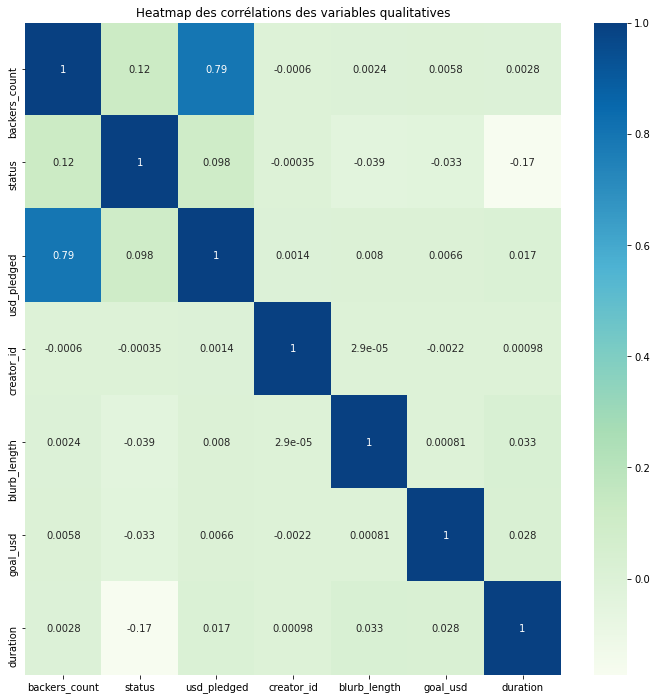

In [ ]:
dfcor = df.loc[:, df.columns != 'id']
cor = dfcor.corr()
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(cor, annot= True, ax= ax, cmap="GnBu").set(title= "Heatmap des corrélations des variables qualitatives");

Les variables ‘usd pledged’ et ‘backers_count’ sont assez corrélées.
En effet, le montant collecté d’un projet dépend grandement de ses contributeurs.

In [ ]:
table = pd.crosstab(df["city"],df["country"])

from scipy.stats import chi2_contingency

resultats_test = chi2_contingency(table)
statistique = resultats_test[0]
p_valeur = resultats_test[1]
degre_liberte = resultats_test[2]

print(statistique,p_valeur,degre_liberte)

3488408.6239253525 0.0 308880


In [ ]:
def V_Cramer (table,N):
    stat_chi2 = chi2_contingency(table)[0]
    k = table.shape[0]
    r = table.shape[1]
    phi = max(0,(stat_chi2/N)-((k-1)*(r-1)/(N-1)))
    k_corr = k - (np.square(k-1)/(N-1))
    r_corr = r - (np.square(r-1)/(N-1))
    return np.sqrt(phi/min(k_corr - 1,r_corr - 1))

V_Cramer(table,df.shape[0])

0.8465186706319164

La p-valeur étant inférieure à 5% les deux variables sont ainsi dépendantes. 
Le V_Cramer n'est pas tres élevé, on en déduit qu'il n'y a pas de forte corrélation entre les deux variables mais qu'elle n'est pas negligeable, certainement du à l'attrait de certaines villes plus pronnoncé que d'autres.
Pour la fluidité du traitement, nous ne garderons que la variable country.

In [ ]:
table2 = pd.crosstab(df["currency"],df["country"])

from scipy.stats import chi2_contingency

resultats_test2 = chi2_contingency(table2)
statistique = resultats_test2[0]
p_valeur = resultats_test2[1]
degre_liberte = resultats_test2[2]

print(statistique,p_valeur,degre_liberte)

2461217.0334905526 0.0 336


In [ ]:
V_Cramer(table2,df.shape[0])

0.9750580066000503

La corrélation pays/ currency est évidente, nous n'utilisons pas la variable currency durant notre étude

In [ ]:
df['launched_at'] = pd.to_datetime(df['launched_at'], errors='coerce')
df['launched_at_mois']= df['launched_at'].dt.strftime('%m')

In [ ]:
# spliter la variable lauched_at 
df['launched_at_jour']= df['launched_at'].dt.day
df['launched_at_an']= df['launched_at'].dt.year
df['launched_at_mois']= df['launched_at_mois'].astype(str).astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184899 entries, 0 to 184898
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   id                184899 non-null  int64         
 1   name              184899 non-null  object        
 2   currency          184899 non-null  object        
 3   launched_at       184899 non-null  datetime64[ns]
 4   backers_count     184899 non-null  int64         
 5   blurb             184899 non-null  object        
 6   country           184899 non-null  object        
 7   deadline          184899 non-null  object        
 8   slug              184899 non-null  object        
 9   status            184899 non-null  int64         
 10  usd_pledged       184899 non-null  float64       
 11  main_category     184899 non-null  object        
 12  sub_category      184899 non-null  object        
 13  creator_id        184899 non-null  int64         
 14  blur

In [ ]:
########### data set nettoyé à utiliser sur streamlit ############
dfst  = df.to_csv('dfst.csv')
from IPython.display import FileLink
FileLink('dfst.csv')
##################################################################

/content/dfst.csv

In [ ]:
df.launched_at = pd.to_datetime(df.launched_at).dt.date
df.deadline = pd.to_datetime(df.deadline).dt.date

df['Difference'] = df['deadline'].sub(df['launched_at'], axis=0)
df['Difference'] = df['Difference'] / np.timedelta64(1, 'D')
#df['Difference'].equals(df['duration']) # nous retrouvons un false car pour certaines lignes elles different d'un jour
df.head(10)

,id,name,currency,launched_at,backers_count,blurb,country,deadline,slug,status,usd_pledged,main_category,sub_category,creator_id,blurb_length,goal_usd,city,duration,launched_at_mois,launched_at_jour,launched_at_an,Difference
0,1714728788,Urban Farm Kits: Our Solution to City Farming,CAD,2018-02-10,16,"Earn $1,000 - $20,000+ by transforming idle re...",CA,2018-04-11,urban-farm-kits-our-solution-to-city-farming,0,577.902078,food,Farms,41046209,122,785.820650,Victoria,60.0,2,10,2018,60.0
1,1639965256,Reflections on the LHC Safety Report,USD,2014-11-21,7,"Need Peer Review, Open Source style",US,2014-12-15,reflections-on-the-lhc-safety-report-review-an...,1,211.000000,publishing,Academic,1877377173,35,93.000000,San Diego,24.0,11,21,2014,24.0
2,1582062943,Ultra-Custom Chocolate Bars,USD,2020-10-19,99,Ultra-customized bean to bar chocolate. Any fl...,US,2020-11-18,ultra-custom-chocolate-bars-0,1,4697.000000,food,Small Batch,205122366,122,1500.000000,Philadelphia,30.0,10,19,2020,30.0
3,1888984372,GlassWeb: Internet Monitoring,USD,2019-05-29,3,A module device to monitor internet connection...,US,2019-07-28,glassweb-internet-monitoring,0,222.000000,technology,Gadgets,1458852038,69,25000.000000,Chicago,60.0,5,29,2019,60.0
4,1409770586,Dreaming of Streaming - 96.9 FM KMRD-LP Madrid...,USD,2015-11-19,100,"Madrid's low power FM community radio station,...",US,2015-12-19,dreaming-of-streaming-969-fm-kmrd-lp-madrid-ne...,1,5410.000000,publishing,Radio & Podcasts,1845213665,131,5000.000000,Madrid,30.0,11,19,2015,30.0
5,1184883770,The Breaks Season 1.5 (Episodes 4-9),USD,2014-03-14,106,The Breaks is a web series about a sports card...,US,2014-04-15,the-breaks-season-15-episodes-4-9,1,5782.000000,film & video,Webseries,2129431571,134,4000.000000,Los Angeles,31.0,3,14,2014,32.0
6,673847406,Ninty Fresh Issue 2,GBP,2020-09-21,1156,The second issue of the new Nintendo Magazine ...,GB,2020-11-05,ninty-fresh-issue-2,1,19829.398979,publishing,Zines,80879057,93,3366.713175,Essex,45.0,9,21,2020,45.0
7,651838967,Tarot Card Deck based on Golden Age of Horror ...,USD,2018-07-20,75,Amazing images from the Golden Age of Horror C...,US,2018-08-03,tarot-card-deck-based-on-golden-age-of-horror-...,1,2659.000000,games,Playing Cards,1468389582,127,1500.000000,Houston,14.0,7,20,2018,14.0
8,1866245772,"HOWLinfuse, the First Organic Kombucha Tea Kit...",USD,2017-05-18,17,A Certified Organic Kombucha Tea Kit - monthly...,US,2017-06-26,howlinfuse-the-first-organic-kombucha-tea-kit-...,1,2550.000000,food,Drinks,1287334430,135,2500.000000,Minneapolis,38.0,5,18,2017,39.0
9,736120028,Adaptogen & Nootropic-Infused Bean-to-Bar Choc...,USD,2020-06-30,121,EAT GOLD ORGANICS : Organic and handcrafted in...,US,2020-07-21,adaptogen-and-nootropic-infused-bean-to-bar-ch...,1,9336.220000,food,Vegan,504722009,116,5000.000000,Brooklyn,21.0,6,30,2020,21.0


Toujours dans le but d'alléger le dataset étudié nous ne garderons que la variable duration, la variable deadline étant redondante.

In [ ]:
import numpy as np
import pandas as pd
def outliers(s):
    iqr = (np.quantile(s, 0.75))-(np.quantile(s, 0.25))
    upper_bound = np.quantile(s, 0.75)+(1.5*iqr)
    lower_bound = np.quantile(s, 0.25)-(1.5*iqr)
    f = []
    for i in s:
        if i > upper_bound:
            f.append(i)
        elif i < lower_bound:
            f.append(i)
    sums = len(f)
    pros = len(f)/len(s)*100
    d = {'IQR':iqr,
         'Upper Bound':upper_bound,
        'Lower Bound':lower_bound,
        'Sum outliers': sums,'percentage outliers':pros}
    d = pd.DataFrame(d.items(),columns = ['sub','values'])
    return(d)
    
outliers(df.goal_usd)

,sub,values
0,IQR,10664.784200
1,Upper Bound,28161.960500
2,Lower Bound,-14497.176300
3,Sum outliers,22341.000000
4,percentage outliers,12.082813


Les valeurs aberrantes récapitulatives montrent que la variable goal_usd a 22182 valeurs aberrantes et le pourcentage est de 11.2%. Le nombre étant important nous envisageons de verifier qu'il ne s'agisse pas de valeurs aberrantes. (voir plus bas dans #saisonnalité oú les montants sont certes élevés mais cohérents)

# Vizualisations

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


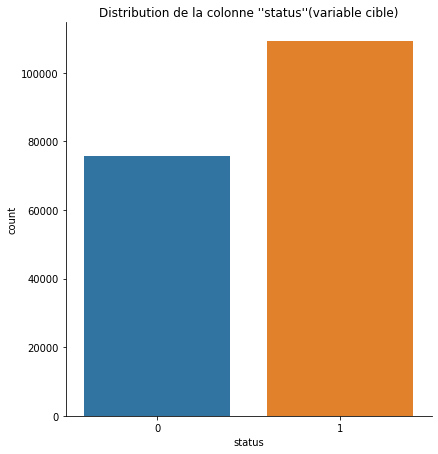

In [ ]:
sns.catplot('status',data=df,kind='count', height=6).set(title="Distribution de la colonne ''status''(variable cible)");

Les lignes aux statut live et canceled ont ete supprimés afin d'avoir une meilleuree visibilité dans la modelisation

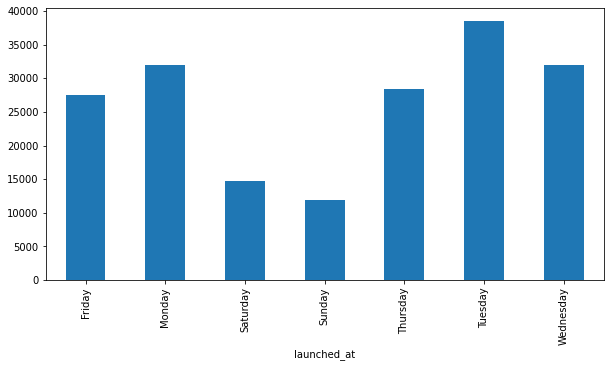

In [ ]:
df.groupby([(pd.to_datetime(df.launched_at).dt.strftime("%A"))]).size().plot(kind='bar',figsize=(10,5));

On constate des jours faibles en lancement de projets.

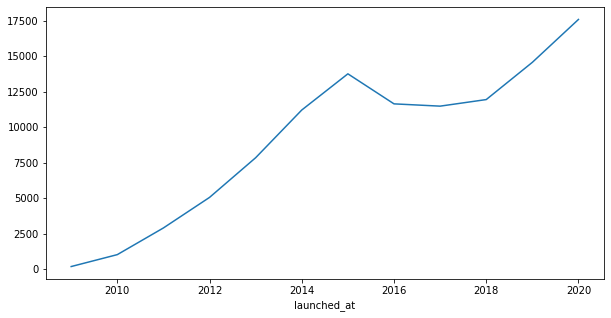

In [ ]:
df[df.status == 1].groupby([(pd.to_datetime(df.launched_at).dt.year)]).size().plot(figsize=(10,5))

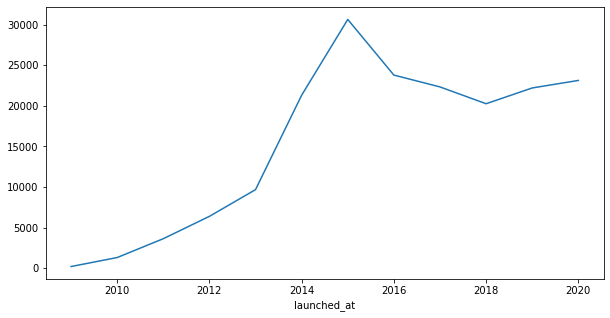

In [ ]:
df.status.groupby([(pd.to_datetime(df.launched_at).dt.year)]).size().plot(figsize=(10,5))

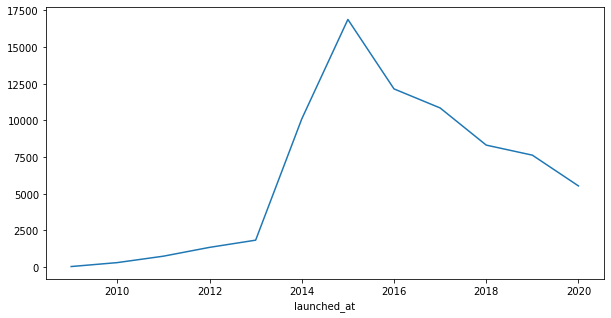

In [ ]:
df[df.status == 0].groupby([(pd.to_datetime(df.launched_at).dt.year)]).size().plot(figsize=(10,5))

Un pic est constaté en 2015, suivi d'une décroissance enregistrée jusqu'à 2018.  A partir de 2018 une évolution positive et franche se prolonge jusqu'à 2020.

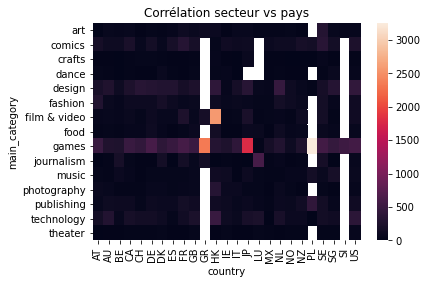

In [ ]:
pivot_table = df.pivot_table(index='main_category', 
                   columns='country', 
                   values='backers_count', 
                   aggfunc='mean')
sns.heatmap(pivot_table).set(title="Corrélation secteur vs pays");


Certaines corrélations sont très fortes, entre certains pays (GR: Grèce, PL: Pologne, SI:  Slovénie) et secteurs d'activité

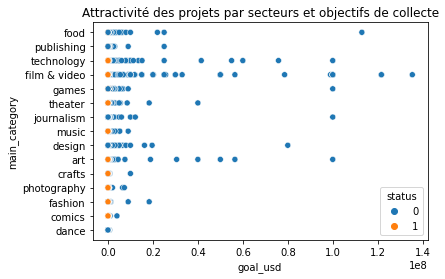

In [ ]:
import seaborn as sns
sns.scatterplot(data=df, x="goal_usd", y="main_category", hue= 'status').set(title="Attractivité des projets par secteurs et objectifs de collecte");


La visualisation démontre clairement  que l’échec d’un projet est dû en grande partie à un besoin en financement trop important aux yeux des contributeurs.
Il existe donc un seuil a prendre en considération.

In [ ]:
success=df[df.status== 1]
a= success.goal_usd.mean()
print('l objectif moyen des projets aboutis est de:', a)

failed=df[df.status== 0]
b= failed.goal_usd.mean()
print('l objectif moyen des projets non aboutis est de:', b)    

l objectif moyen des projets aboutis est de: 8866.983273343298
l objectif moyen des projets non aboutis est de: 82315.37522031908


La durée est un facteur déterminant dans le choix des projets.
30 jours est la durée la plus appréciée par les apporteurs de fonds.

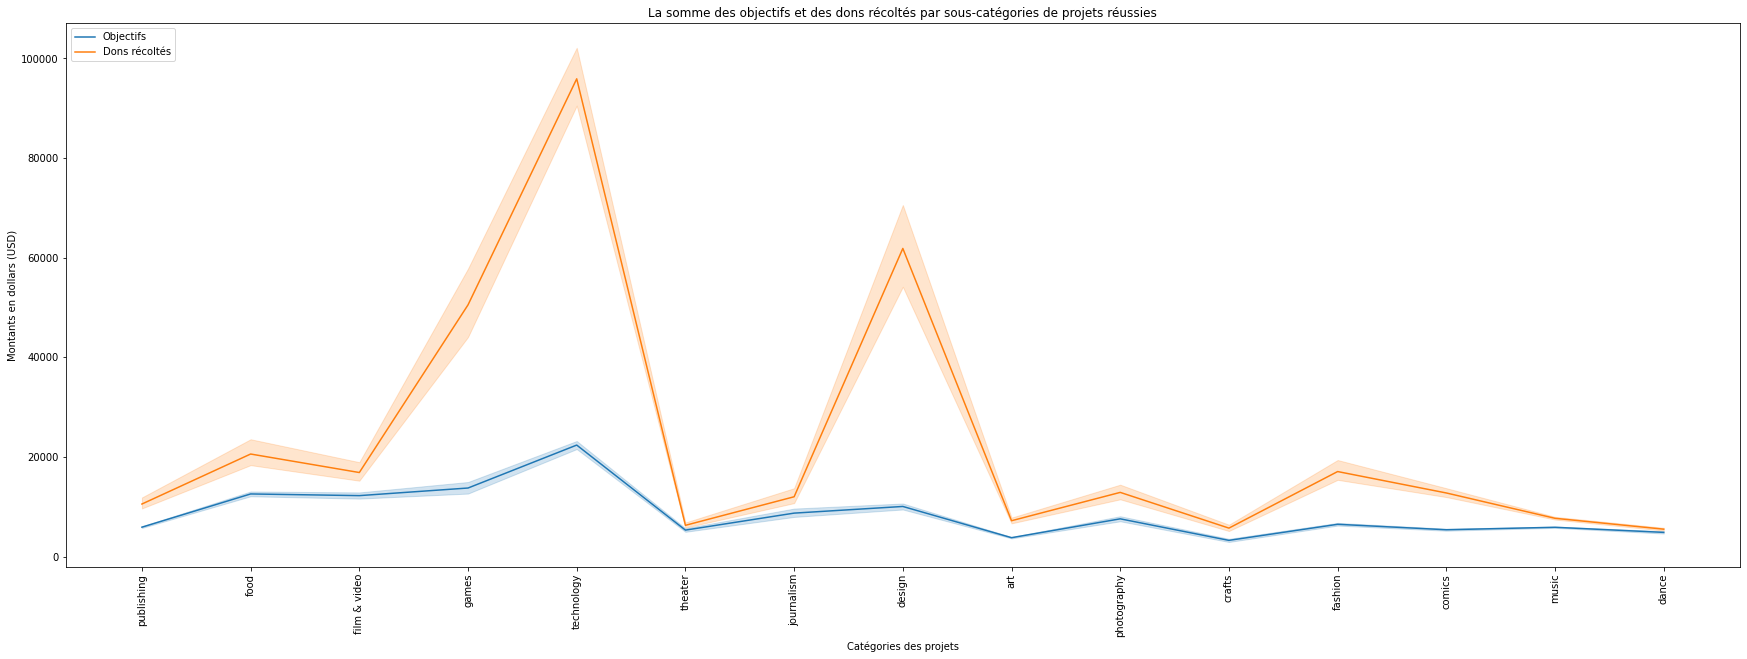

In [ ]:
kick_data_goal_pledge = df[(df.status == 1)]
plt.figure(figsize=(30,10))
sns.lineplot(data=kick_data_goal_pledge, x= kick_data_goal_pledge.main_category, y=kick_data_goal_pledge.goal_usd)
sns.lineplot(data=kick_data_goal_pledge, x= kick_data_goal_pledge.main_category, y=kick_data_goal_pledge.usd_pledged)
plt.title("La somme des objectifs et des dons récoltés par sous-catégories de projets réussies", fontsize=12)
plt.xlabel("Catégories des projets")
plt.ylabel("Montants en dollars (USD)")
plt.xticks(rotation = 90)
plt.legend(['Objectifs', 'Dons récoltés'], loc='upper left')
plt.show()



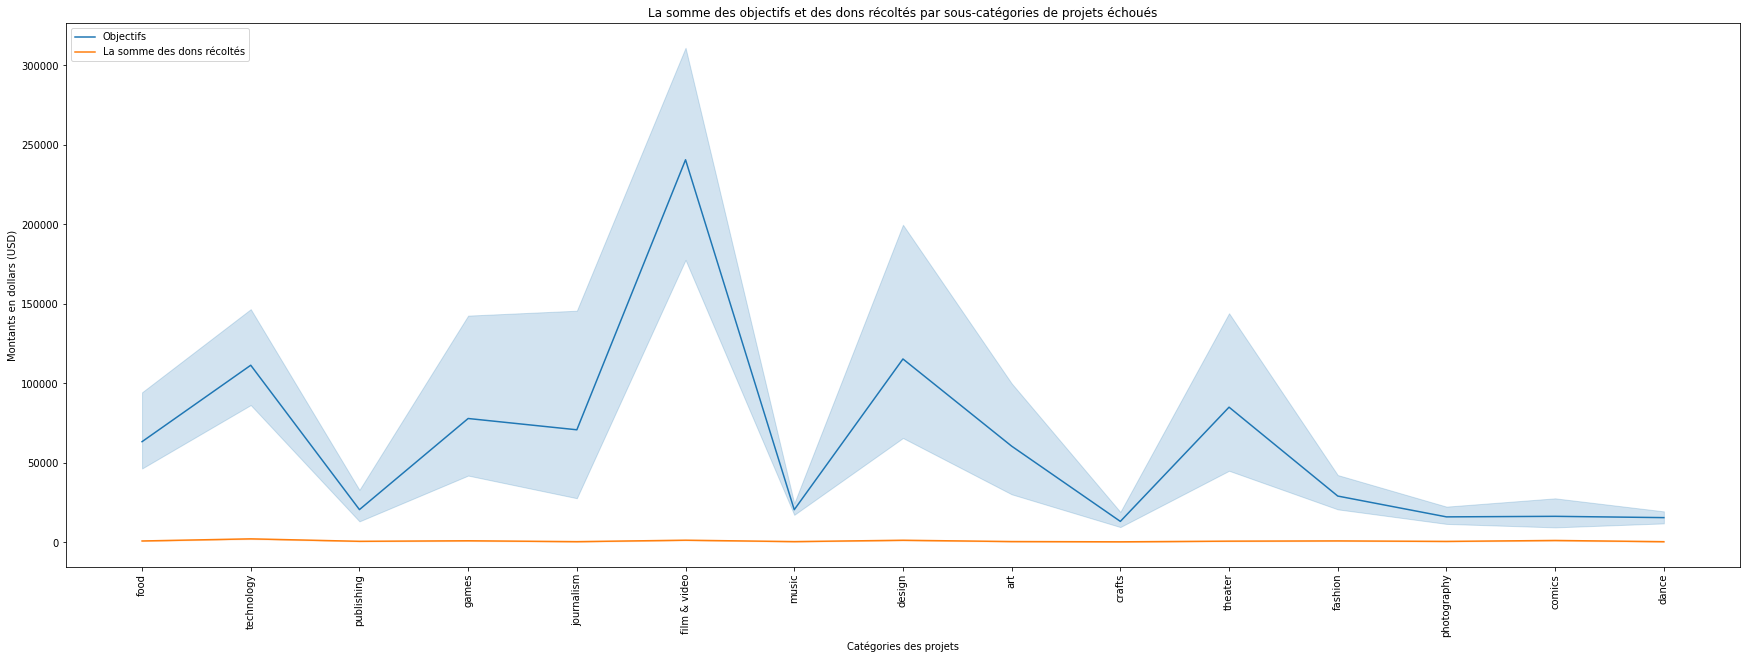

In [ ]:
kick_data_goal_pledge = df[(df.status == 0)]
plt.figure(figsize=(30,10))
sns.lineplot(data=kick_data_goal_pledge, x= kick_data_goal_pledge.main_category, y=kick_data_goal_pledge.goal_usd)
sns.lineplot(data=kick_data_goal_pledge, x= kick_data_goal_pledge.main_category, y=kick_data_goal_pledge.usd_pledged)
plt.title("La somme des objectifs et des dons récoltés par sous-catégories de projets échoués", fontsize=12)
plt.xlabel("Catégories des projets")
plt.ylabel("Montants en dollars (USD)")
plt.xticks(rotation = 90)
plt.legend(['Objectifs', 'La somme des dons récoltés'], loc='upper left')
plt.show()

Ce graphique nous permet de visualiser les écarts entre les objectifs et les dons récoltés par sous-catégorie.

Les catégories ‘technology’, ‘design’, ‘games’ ont tendance à récolter plus d’argent que les objectifs fixés 
par les créateurs de projets.

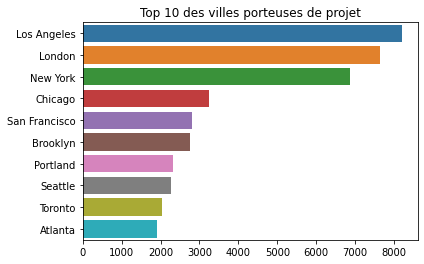

In [ ]:
sns.barplot(y=df.city.value_counts().head(10).index,
            x=df.city.value_counts().head(10).values).set(title='Top 10 des villes porteuses de projet');


In [ ]:
sns.barplot(y=df.country.value_counts().head(10).index,
            x=df.country.value_counts().head(10).values).set(title='Top 10 des pays les plus porteurs de projet');

In [ ]:
plt.figure(figsize=(12,8))
sns.countplot(x="country", hue="status", data=df).set(title='Différence entre les projets échoués (0) et les projets réussis (1) par pays');
plt.xlabel("Pays")
plt.ylabel("Nombre de projet")
plt.legend(['0: Echoué',  '1: Réussi '], loc='upper right')

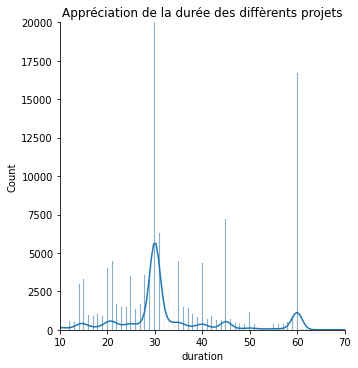

In [ ]:
sns.displot(df['duration'], kde=True).set(title="Appréciation de la durée des diffèrents projets")
plt.axis([10,70,0,20000]);

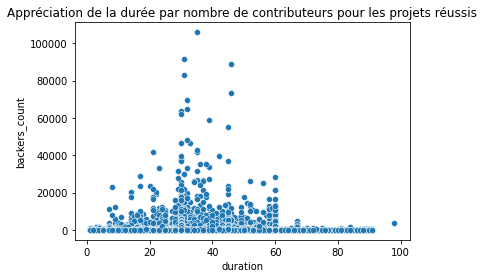

In [ ]:
sns.scatterplot(data=df[df.status == 1], x="duration", y="backers_count").set(title="Appréciation de la durée par nombre de contributeurs pour les projets réussis");

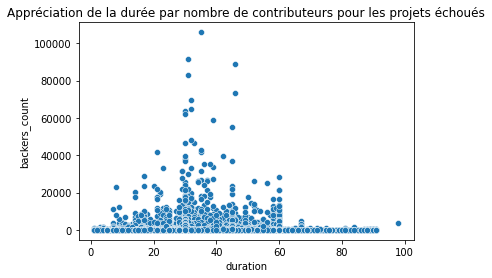

In [ ]:
sns.scatterplot(data=df[df.status == 1], x="duration", y="backers_count").set(title="Appréciation de la durée par nombre de contributeurs pour les projets échoués");

Le top10 des villes se situent majoritairement dans les pays anglo saxons. 
Du fait de la généralisation de ce mode de financement.

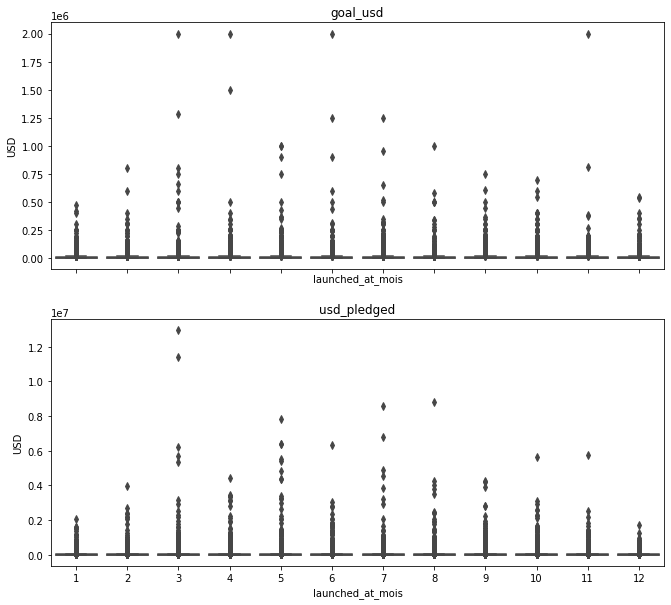

In [ ]:
## saisonnalité
#df['launched_at'] = pd.to_datetime(df['launched_at'], errors='coerce')
#df['launched_at_mois']= df['launched_at'].dt.strftime('%m')
import seaborn as sns

fig, axes = plt.subplots(2, 1, figsize=(11, 10), sharex=True)

for name, ax in zip(['goal_usd', 'usd_pledged'], axes):
    sns.boxplot(data=df[df.status == 1], x='launched_at_mois', y=name, ax=ax).set(title= "Saisonnalité")
    ax.set_ylabel('USD')
    ax.set_title(name)

if ax != axes[-1]:
    ax.set_xlabel('')

Malgré des objectifs plus élevés que la moyenne, on constate que les projets lancés durant les mois de : mars, mai, juillet, août ont obtenus les fonds demandés.La variable montants collectés (plegged_usd) enregistre des collectes importantes durant les mois de : mars, juillet, août, mai.

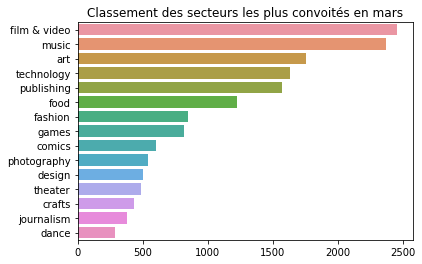

In [ ]:
zoom_s=df[df.launched_at_mois == 3]

sns.barplot(y=zoom_s['main_category'].value_counts().head(15).index,
            x=zoom_s['main_category'].value_counts().head(15).values).set(title='Classement des secteurs les plus convoités en mars');


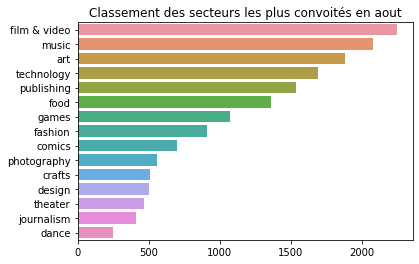

In [ ]:
zoom_s=df[df.launched_at_mois == 8]

sns.barplot(y=zoom_s['main_category'].value_counts().head(15).index,
            x=zoom_s['main_category'].value_counts().head(15).values).set(title='Classement des secteurs les plus convoités en aout');

Le top 3 des main_categorie ne change pas pendant les mois a forte influence

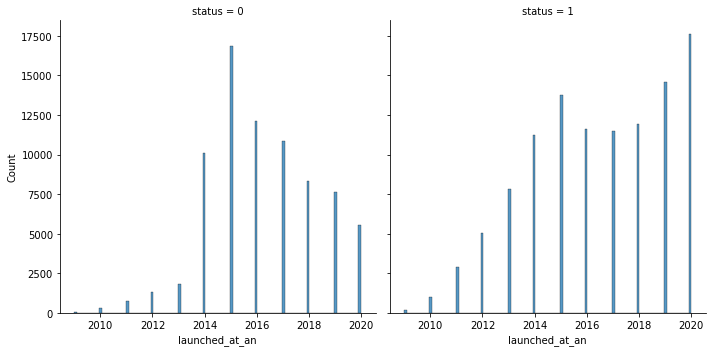

In [ ]:
sns.displot(data=df, x="launched_at_an", col="status");
#.set(title='Representation des projets suivant la variable statuts par année');

# Itération 1

De ce qui précède, nous supprimons les variables suivantes: 

*   unname 0, id, name, creator_id
*   currency et city, du fait de leurs corrélation a la variable country 
*   sub_category, du fait de leurs corrélation a la variable main_category
*   launched_at, cette variable a été splitée sur trois nouvelles variables (launched_at_mois, launched_at_jour, launched_at_an)
*   deadline et Difference, cette variable est redondante avec la variable duration
*   usd_pledged et backers_count , car ces variables ne peuvent jouer un rôle dans un processus predictif
*   blurb et slug, car ces variables seront stockees afin de les utiliser dans un modele words cloud


In [ ]:
# stocker dans w_df les colonnes blurb et slug
w_df = df.assign(column_new_1='blurb', column_new_2= 'slug', column_new_3='status')

#suppression justifiées des colonnes
columns_to_drop = ['id', 'name', 'creator_id', 'currency', 'city', 'sub_category', 'launched_at', 'deadline', 'usd_pledged', 'backers_count', 'blurb', 'slug', 'Difference']
df=df.drop(columns=columns_to_drop, axis=1)



La Selection des variables numériques

La Standardisation des variables numériques

In [ ]:
# les variables numériques
df['status'] = df['status'].astype('object')
num_df = df.select_dtypes(include=[np.number])
num_df[num_df.columns] = pd.DataFrame(preprocessing.StandardScaler().fit_transform(num_df))
num_df

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,blurb_length,goal_usd,duration,launched_at_mois,launched_at_jour,launched_at_an
0,0.457994,-0.034879,2.226284,-1.354140,-0.587868,0.671497
1,-2.469849,-0.035513,-0.733962,1.373562,0.651998,-0.965671
2,0.457994,-0.034226,-0.240588,1.070484,0.426568,1.490081
3,-1.325634,-0.012741,2.226284,-0.444906,1.553718,1.080789
4,0.760874,-0.031026,-0.240588,1.373562,0.426568,-0.556379
...,...,...,...,...,...,...
184894,-0.618914,-0.035290,-0.240588,-1.354140,-1.151443,1.490081
184895,0.558954,-0.035140,0.992848,-0.444906,1.779148,0.262205
184896,-0.618914,0.001541,1.403993,-1.657218,1.441003,-0.556379
184897,0.054154,-0.034360,-0.651733,0.464328,1.666433,-0.556379


In [ ]:
# les variables catégorielles
df['status'] = df['status'].astype('int')
cat_df = df.select_dtypes(exclude=[np.number])

# Transformation des variables indicatrices
cat_df = pd.get_dummies(cat_df, dtype=float)
cat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184899 entries, 0 to 184898
Data columns (total 40 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   country_AT                  184899 non-null  float64
 1   country_AU                  184899 non-null  float64
 2   country_BE                  184899 non-null  float64
 3   country_CA                  184899 non-null  float64
 4   country_CH                  184899 non-null  float64
 5   country_DE                  184899 non-null  float64
 6   country_DK                  184899 non-null  float64
 7   country_ES                  184899 non-null  float64
 8   country_FR                  184899 non-null  float64
 9   country_GB                  184899 non-null  float64
 10  country_GR                  184899 non-null  float64
 11  country_HK                  184899 non-null  float64
 12  country_IE                  184899 non-null  float64
 13  country_IT    

In [ ]:
target = df['status']
df = num_df.join(pd.get_dummies(cat_df, dtype = float))
df

,blurb_length,goal_usd,duration,launched_at_mois,launched_at_jour,launched_at_an,country_AT,country_AU,country_BE,country_CA,country_CH,country_DE,country_DK,country_ES,country_FR,country_GB,country_GR,country_HK,country_IE,country_IT,country_JP,country_LU,country_MX,country_NL,country_NO,country_NZ,country_PL,country_SE,country_SG,country_SI,country_US,main_category_art,main_category_comics,main_category_crafts,main_category_dance,main_category_design,main_category_fashion,main_category_film & video,main_category_food,main_category_games,main_category_journalism,main_category_music,main_category_photography,main_category_publishing,main_category_technology,main_category_theater
0,0.457994,-0.034879,2.226284,-1.354140,-0.587868,0.671497,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-2.469849,-0.035513,-0.733962,1.373562,0.651998,-0.965671,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.457994,-0.034226,-0.240588,1.070484,0.426568,1.490081,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.325634,-0.012741,2.226284,-0.444906,1.553718,1.080789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.760874,-0.031026,-0.240588,1.373562,0.426568,-0.556379,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184894,-0.618914,-0.035290,-0.240588,-1.354140,-1.151443,1.490081,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
184895,0.558954,-0.035140,0.992848,-0.444906,1.779148,0.262205,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
184896,-0.618914,0.001541,1.403993,-1.657218,1.441003,-0.556379,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
184897,0.054154,-0.034360,-0.651733,0.464328,1.666433,-0.556379,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
#On sépare la variable Status dans target et le reste des variables dans feats

feats = df

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(feats, target, test_size = 0.2)

# 1/ K-plus proches voisins




In [ ]:
## K-plus proches voisins. 

from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
#timer
start= timer()

#model
k_range = list(range(2,50))

param_grid = dict(n_neighbors = k_range)

knn = KNeighborsClassifier()

grid = GridSearchCV(knn, param_grid, scoring = 'accuracy')
grid.fit(X_test,y_test)

print (grid.best_score_)
print (grid.best_params_)
print (grid.best_estimator_)

#calcule le temps de l'exécution 
end = timer()
print("Time taken  :", round(((end-start)/60),2), 'Minute')

0.6852352623039482
{'n_neighbors': 48}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=48, p=2,
                     weights='uniform')
Time taken  : 45.43 Minute


In [ ]:
## K-plus proches voisins.matrice+score
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import confusion_matrix

#timer
start= timer()

classifier = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=49, p=2,
                     weights='uniform')
classifier.fit(X_train, y_train)

#Les prédictions
y_predknn = classifier.predict (X_test)


#print("Confusion Matrix: ") 
pd.crosstab(y_test, y_predknn, rownames=['Classe réelle'], colnames=['Classe prédite'])

#calcule le temps de l'exécution 
end = timer()
print("Time taken  :", round(((end-start)/60),2), 'Minute')
pd.crosstab(y_test, y_predknn, rownames=['Classe réelle'], colnames=['Classe prédite'])

Time taken  : 2.8 Minute


Classe prédite,0,1
Classe réelle,,
0,8519,6622
1,4508,17331


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_predknn))

              precision    recall  f1-score   support

           0       0.65      0.56      0.60     15141
           1       0.72      0.79      0.76     21839

    accuracy                           0.70     36980
   macro avg       0.69      0.68      0.68     36980
weighted avg       0.70      0.70      0.69     36980



# 2/ Régression logistique 

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

#timer
start= timer()

params = {'penalty':['l1','l2'],'C':[1,2,3,4,5]}

lr = LogisticRegression()
lr_gs = GridSearchCV(lr, params, cv=3, verbose=1).fit(X_train, y_train)

print("Best Params", lr_gs.best_params_)
print("Best Score", lr_gs.best_score_)

#calcule le temps de l'exécution 
end = timer()
print("Time taken  :", round(((end-start)/60),2), 'Minute')


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940:

Best Params {'C': 4, 'penalty': 'l2'}
Best Score 0.6800681377421807


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
#timer
start= timer()

clf = LogisticRegression(C=1, penalty='l2')
clf_fit = clf.fit(X_train, y_train)

#Les prédictions
y_predrl = clf.predict (X_test)

#print("Confusion Matrix: ") 


#calcule le temps de l'exécution 
end = timer()
print("Time taken  :", round(((end-start)/60),2), 'Minute')
pd.crosstab(y_test, y_predrl, rownames=['Classe réelle'], colnames=['Classe prédite'])

Time taken  : 0.06 Minute


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Classe prédite,0,1
Classe réelle,,
0,6820,8321
1,3510,18329


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_predrl))
accuracy_score(y_test, y_predrl)

              precision    recall  f1-score   support

           0       0.66      0.45      0.54     15141
           1       0.69      0.84      0.76     21839

    accuracy                           0.68     36980
   macro avg       0.67      0.64      0.65     36980
weighted avg       0.68      0.68      0.67     36980



0.6800703082747431

# 3/ RandomForest

In [ ]:
#RandomForest. Hyperparamètres à régler :
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
#timer
start= timer()

dt=DecisionTreeClassifier()

parameter_grid = {'max_features': ["sqrt", "log2", None],
                  'min_samples_split': list(range(2,31,2))}

grid_search = GridSearchCV(dt, param_grid = parameter_grid)

grid_search.fit(X_train, y_train)

print ("Best Score: {}".format(grid_search.best_score_))
print("---------------------------------------------------")
print ("Best params: {}".format(grid_search.best_params_))

#calcule le temps de l'exécution 
end = timer()
print("Time taken  :", round(((end-start)/60),2), 'Minute')


Best Score: 0.679155480669315
---------------------------------------------------
Best params: {'max_features': 'log2', 'min_samples_split': 30}
Time taken  : 2.51 Minute


In [ ]:
#RandomForest. Hyperparamètres à régler :
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#timer
start= timer()

dt_clf = DecisionTreeClassifier(min_samples_split=30, max_features= 'log2')
dt_clf.fit(X_train, y_train)

y_predrf = dt_clf.predict(X_test)


#calcule le temps de l'exécution 
end = timer()
print("Time taken  :", round(((end-start)/60),2), 'Minute')

#print("Confusion Matrix: ") 
pd.crosstab(y_test, y_predrf, rownames=['Classe réelle'], colnames=['Classe prédite'])

Time taken  : 0.01 Minute


Classe prédite,0,1
Classe réelle,,
0,8978,6163
1,5689,16150


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_predrf))

              precision    recall  f1-score   support

           0       0.61      0.60      0.60     15035
           1       0.73      0.74      0.74     21945

    accuracy                           0.68     36980
   macro avg       0.67      0.67      0.67     36980
weighted avg       0.68      0.68      0.68     36980



# 4/ XGBOOST

In [ ]:
# # XGBOOST
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score
#timer
start= timer()

# XGBOOST
XGB_classifier = XGBClassifier()
XGB_classifier.fit(X_train, y_train)
print(XGB_classifier)

# on fait les prédictions sur les données test
XGB_preds = XGB_classifier.predict(X_test)
predictions = [round(value) for value in XGB_preds]

# on évalue la prédiction
accuracy = accuracy_score(y_test, predictions)
print("Accuracy of XGB classifier: %.2f%%" % (accuracy * 100.0))

#calcule le temps de l'exécution 
end = timer()
print("Time taken  :", round(((end-start)/60),2), 'Minute')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Accuracy of XGB classifier: 71.56%
Time taken  : 0.31 Minute


In [ ]:

#print("Confusion Matrix: ") 
print(pd.crosstab(y_test, XGB_preds, rownames=['Classe réelle'], colnames=['Classe prédite']))
print("---------------------------------------------------")
from sklearn.metrics import classification_report
print(classification_report(y_test,XGB_preds))
pd.crosstab(y_test, XGB_preds, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite     0      1
Classe réelle              
0               7778   7363
1               3155  18684
---------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.51      0.60     15141
           1       0.72      0.86      0.78     21839

    accuracy                           0.72     36980
   macro avg       0.71      0.68      0.69     36980
weighted avg       0.71      0.72      0.71     36980



Classe prédite,0,1
Classe réelle,,
0,7778,7363
1,3155,18684


Ce dernier modele obtient le meilleur pourcentage.

# Itération 2

1/ Amélioration du score XGBOOST

In [ ]:
## Amelioration du score XGBOOST

grid = {'max_depth':10}
XGB_classifier_II = XGBClassifier()
XGB_classifier_II.max_depth

XGB_classifier_II.set_params(**grid)


XGB_classifier_II.fit(X_train, y_train)

# on fait les prédictions sur les données test
XGB__II_preds = XGB_classifier_II.predict(X_test)


# on évalue la prédiction
accuracy_II = accuracy_score(y_test, XGB__II_preds)
print("Accuracy of XGB classifier V2: %.2f%%" % (accuracy_II * 100.0))

Accuracy of XGB classifier V2: 73.21%


In [ ]:
#print("Confusion Matrix: ") 
print(pd.crosstab(y_test, XGB__II_preds, rownames=['Classe réelle'], colnames=['Classe prédite']))
print("---------------------------------------------------")
from sklearn.metrics import classification_report
print(classification_report(y_test,XGB__II_preds))

Classe prédite     0      1
Classe réelle              
0               8972   6063
1               3905  18040
---------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.60      0.64     15035
           1       0.75      0.82      0.78     21945

    accuracy                           0.73     36980
   macro avg       0.72      0.71      0.71     36980
weighted avg       0.73      0.73      0.73     36980



2/ Interprétabilité

In [ ]:
!pip install shap

     |████████████████████████████████| 356 kB 6.5 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491657 sha256=f4ff0f9f85a4d0ade0e40e10c2501075d5b6b958e0e22abed2ed65f5660c43fd
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


In [ ]:
import shap
shap.initjs()

In [ ]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(XGB_classifier)

# Calculate Shap values
row_to_show = 10
data_for_prediction = X_test.iloc[row_to_show]
shap_values = explainer.shap_values(data_for_prediction)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

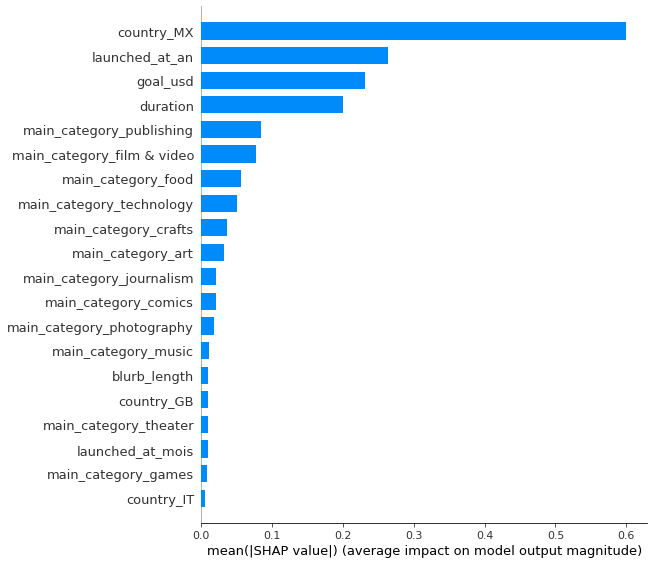

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar")
